In [2]:
#%%
### For Window's Users
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import fiona
import contextily as ctx
import xarray as xr
import shapely
from shapely.geometry import Point
from netCDF4 import Dataset
import datetime
from sklearn.linear_model import LinearRegression




# %%

In [4]:

## Insert flow data
flow_url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb" \
           "&site_no=09506000&referred_module=sw" \
           "&period=&begin_date=1989-01-01&end_date=2021-11-19"
flow_data = pd.read_table(flow_url, sep='\t', skiprows=30,
                          names=['agency_cd', 'site_no', 'datetime', 'flow',
                                 'code'], parse_dates=['datetime'],
                          index_col=['datetime'])
flow_data['month'] = pd.DatetimeIndex(flow_data.index).month
flow_data['day'] = pd.DatetimeIndex(flow_data.index).day
flow_data['year'] = pd.DatetimeIndex(flow_data.index).year




# Because in 2004, the flow is extremely high, cannot use the data before 2004
flow_data.drop(flow_data[flow_data['year'] < 2020].index, inplace=True)
flow_data_2 = flow_data[:]
flow_data = flow_data[:-2]
# drop Nov 12 and 13 because the reanalysis can only reach Nov 11
nov_flow = flow_data[flow_data['month'] == 11]
# %%
# Read in NetCDF Precipitation Data
precip_path = os.path.join('..', 'data', 'Hierarchical_Data',
                           'X70.176.71.70.323.21.41.53.nc')
precip = xr.open_dataset(precip_path)
precip

# Find size of NetCDF precip data
# (2 lat values, 2 lon values, 11993 time values)
precip['prate']['lat'].size
precip['prate']['lon'].size
precip["prate"]["time"].size

# Extract single point, convert it to dataframe to make time series
# Extract years, days, months from datetime index to allow for resampling
# Index 0,0 closest to stream gauge

point_precip = precip["prate"]
precip_df = point_precip.to_dataframe()
precip_df = precip_df.groupby('time').mean()
precip_df['year'] = pd.DatetimeIndex(precip_df.index).year
precip_df['month'] = pd.DatetimeIndex(precip_df.index).month
precip_df['day'] = pd.DatetimeIndex(precip_df.index).day
precip_df.drop(precip_df[precip_df['year'] < 2020].index, inplace=True)


In [5]:

# %%
# Regression and forecast
precip_df

flow_data

# Comnbine streamflow, precip, and air temp into one dataframe
flow_data['precip'] = (precip_df['prate']-np.mean(precip_df['prate']))/np.std(precip_df['prate'])

flow_data

,agency_cd,site_no,flow,code,month,day,year,precip
datetime,,,,,,,,
2020-01-01,USGS,9506000,334.0,A,1,1,2020,-0.217413
2020-01-02,USGS,9506000,300.0,A,1,2,2020,-0.195929
2020-01-03,USGS,9506000,279.0,A,1,3,2020,-0.236212
2020-01-04,USGS,9506000,264.0,A,1,4,2020,-0.222784
2020-01-05,USGS,9506000,256.0,A,1,5,2020,-0.236212
...,...,...,...,...,...,...,...,...
2021-11-13,USGS,9506000,146.0,P,11,13,2021,-0.236212
2021-11-14,USGS,9506000,146.0,P,11,14,2021,-0.230841
2021-11-15,USGS,9506000,146.0,P,11,15,2021,-0.236212


coefficient of determination: 0.64
intercept: 163.25
slope: [3.6000e-01 6.2011e+02]
 This week mean flow is  134.0
 This week mean flow is  117.5


C:\Users\22050\AppData\Local\Temp/ipykernel_26516/682340078.py:34: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(title="Linear regression flow results", xlabel="Time",


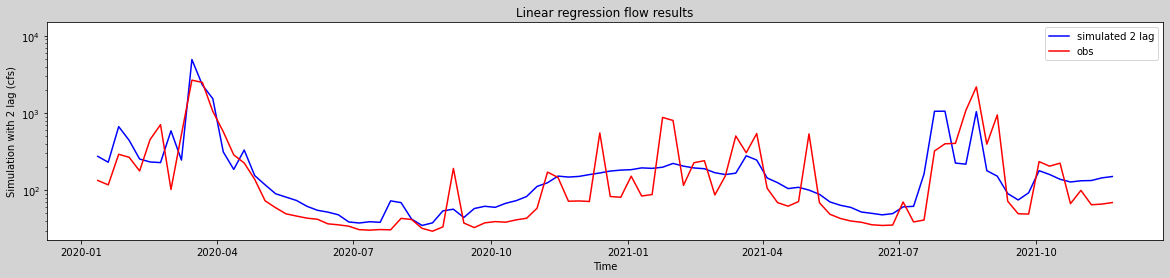

In [7]:

# %%
# Build an autoregressive model
flow_mean = flow_data.resample('W').mean()
flow_mean['flow_tm1'] = flow_mean['flow'].shift(1)

# Using the entire flow data
train = flow_mean[1:][['flow', 'flow_tm1' , 'precip']]

# Build a linear regression model
model = LinearRegression()
x = train[['flow_tm1', 'precip']] 
y = train['flow'].values
model.fit(x, y)

# Results of the model
r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 2))

# Print the intercept and the slope
print('intercept:', np.round(model.intercept_, 2))
print('slope:', np.round(model.coef_, 2))

# Prediction
prediction = model.predict(train[['flow_tm1', 'precip']])
print(" This week mean flow is ", round(prediction[0], 1))
print(" This week mean flow is ", round(prediction[1], 1))
#
# %%
# Line plot comparison of predicted and observed flows
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(flow_mean.index[1:], flow_mean['flow'][1:], color='blue',
        label='simulated 2 lag')
ax.plot(flow_mean.index[1:], prediction, color='red', label='obs')
ax.set(title="Linear regression flow results", xlabel="Time",
       ylabel="Simulation with 2 lag (cfs)",
       yscale='log', ylim=(0, 15000))
ax.legend()
fig.set(facecolor='lightgray')
plt.show()

fig.savefig('linear_regression.jpg', dpi=300, bbox_inches='tight')
